In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Floridablanca_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_5',
                    'Prom_Dia_Preci_2', 'Prom_Dia_Preci_1', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
                    'Total_Preci_Sem', 'Total_Preci_Sem_5', 'Total_Preci_Sem_2',
                    'Total_Preci_Sem_1', 'Total_Preci_Sem_3', 'Total_Preci_Sem_4'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_6', 'Total_Preci_Sem_6'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_6     0
Total_Preci_Sem_6    0
dtype: int64

In [4]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [5]:
f_columns = ['Prom_Dia_Preci_6', 'Total_Preci_Sem_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [6]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


In [9]:
Flori_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Flori_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Flori_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Flori_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Flori_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Flori_MLP_model_6.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Flori_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Flori_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 3s - loss: 0.0470 - val_loss: 0.0944 - 3s/epoch - 206ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0346 - val_loss: 0.0079 - 180ms/epoch - 13ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0296 - val_loss: 0.0062 - 160ms/epoch - 11ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0099 - val_loss: 0.0118 - 85ms/epoch - 6ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0150 - val_loss: 0.0032 - 171ms/epoch - 12ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0103 - val_loss: 0.0017 - 141ms/epoch - 10ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0055 - val_loss: 0.0019 - 94ms/epoch - 7ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0066 - val_loss: 0.0013 - 243ms/epoch - 17ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0054 - val_loss: 0.0015 - 96ms/epoch - 7ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0052 - val_loss: 0.0014 - 100ms/epoch - 7ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0059 - val_loss: 0.0017 - 108ms/epoch - 8ms/step


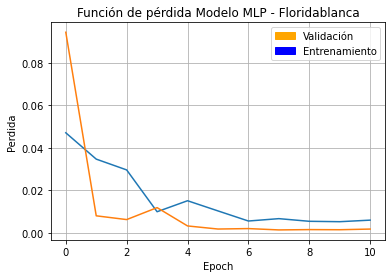

In [10]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Floridablanca')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [11]:
y_pred = Flori_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

6/6 [==============================] - 0s 2ms/step
(1, 429)
(1, 181)
(1, 181)


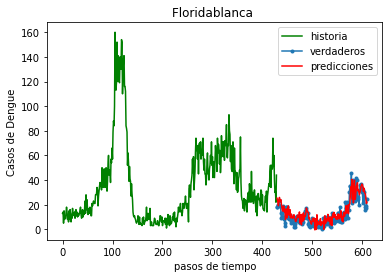

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Floridablanca ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

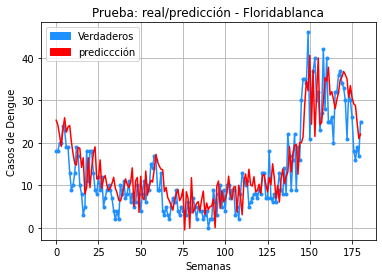

In [13]:
plt.title('Prueba: real/predicción - Floridablanca' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [14]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Floridablanca       : {}".format(score))
print("MSE Floridablanca  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Floridablanca = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Floridablanca  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Floridablanca  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Floridablanca       : 5.741930658567661
MSE Floridablanca  =  32.96976768779925
MAE Floridablanca =  4.485535693668775
r2_score Floridablanca  =  0.6680894510453715
explained_variance_score Floridablanca  =  0.6975087433328307


In [15]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,18.0,25.299973,7.299973
1,18.0,24.178926,6.178926
2,20.0,21.830629,1.830629
3,20.0,19.134912,-0.865088
4,24.0,23.062256,-0.937744
5,23.0,25.892632,2.892632
6,19.0,22.514212,3.514212
7,19.0,23.718317,4.718317
8,13.0,24.071100,11.071100
9,9.0,20.210405,11.210405


In [16]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
121,8.0,8.059772,0.059772
122,13.0,12.289335,-0.710665
123,13.0,12.517151,-0.482849
124,7.0,10.199677,3.199677
125,7.0,8.444985,1.444985
126,18.0,11.833080,-6.166920
127,7.0,10.131985,3.131985
128,6.0,15.060676,9.060676
129,8.0,11.805941,3.805941
130,6.0,6.943891,0.943891
